In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import itertools

In [2]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [3]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

# Label Distribution in Training Data: Skin Condition Sample Count
Displays the number of training images per skin condition (x-axis: image count, y-axis: conditions sorted by frequency).

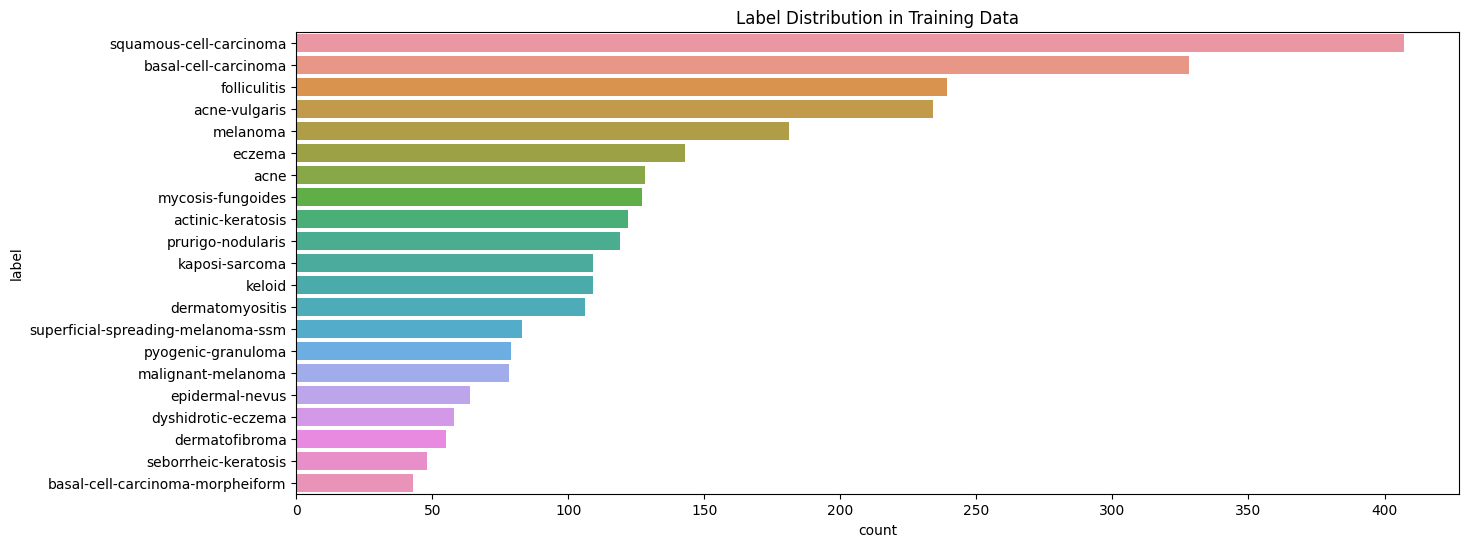

In [4]:
plt.figure(figsize=(15, 6))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index)
plt.title('Label Distribution in Training Data')
plt.show()

## Insights:
* Class Imbalance: Dominant classes (e.g., squamous-cell-carcinoma) vastly outnumber rarer ones (e.g., basal-cell-carcinoma-morpheaform).
* Model Impact: An imbalanced dataset may bias the model toward well-represented classes, reducing accuracy for underrepresented labels.
* Healthcare Implications: Underrepresentation could lead to misdiagnoses in real-world scenarios if not properly addressed.

# Fitzpatrick Scale Distribution
Compares the counts of images grouped into three overarching diagnostic categories—malignant, non-neoplastic, and benign.

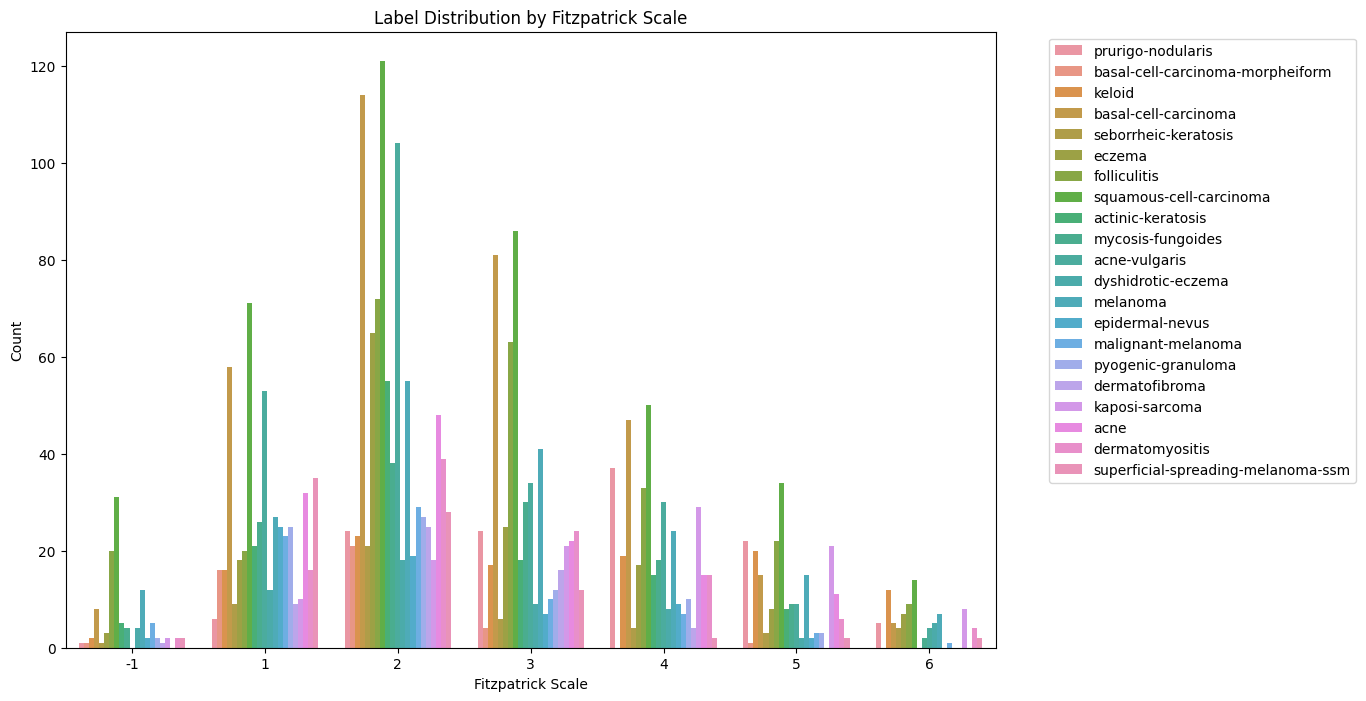

In [5]:
plt.figure(figsize=(12, 8))
sns.countplot(x='fitzpatrick_scale', hue='label', data=train_df,
        order=sorted(train_df['fitzpatrick_scale'].unique()))
plt.title('Label Distribution by Fitzpatrick Scale')
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Insights:
* Imbalance in Samples: Malignant conditions dominate, followed by non-neoplastic, with benign conditions being the least represented.
* Model Bias: A model may learn to better detect malignant features, reducing accuracy for benign and non-neoplastic conditions.
* Clinical Implications: Misclassification can lead to unnecessary treatments or missed diagnoses, impacting patient care.
* Mitigation Strategies: Use data augmentation, class weighting, or collect more benign samples to balance the dataset and improve model performance.

# Three Partition Distribution
Displays how many images exist per Fitzpatrick skin tone (x-axis) and diagnosis label (color/hue).

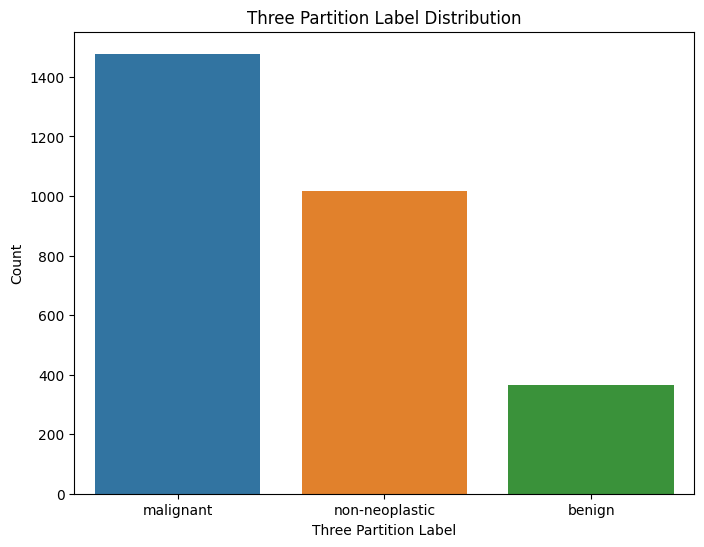

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='three_partition_label', order=train_df['three_partition_label'].value_counts().index)
plt.title('Three Partition Label Distribution')
plt.xlabel('Three Partition Label')
plt.ylabel('Count')
plt.show()

## Insights:
* There are far more images for lighter skin tones (e.g., scale 2 or 3) than darker tones (e.g., scale 5 or 6). This imbalance can cause the model to perform better on lighter tones and poorly on darker ones, potentially perpetuating healthcare disparities.
* Addressing underrepresentation is crucial for fairness and reducing misdiagnosis in darker skin tones; this can be achieved through targeted data augmentation, balanced sampling, and model adjustments like class weighting and fine-tuning.

# Additional Distributions 

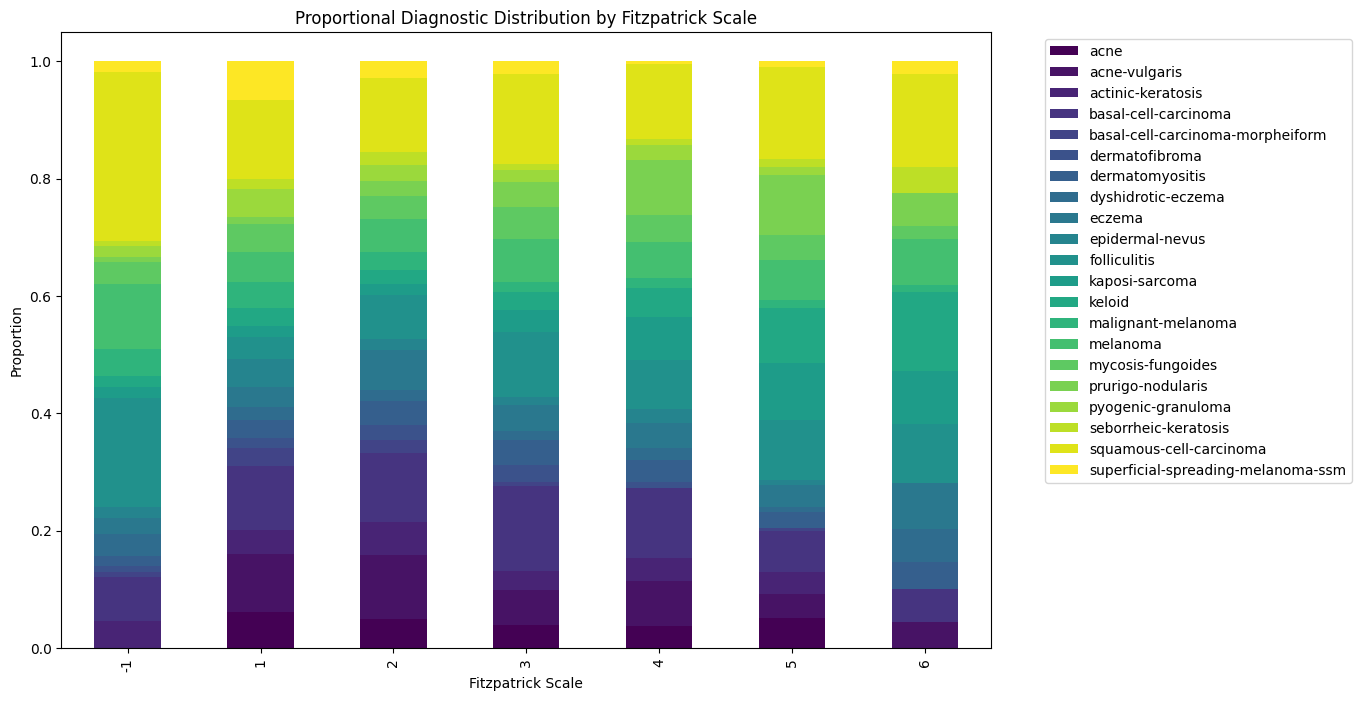

In [6]:
# Create a crosstab of skin tone vs label counts
crosstab = pd.crosstab(train_df['fitzpatrick_scale'], train_df['label'])
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)
    
crosstab_norm.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Proportional Diagnostic Distribution by Fitzpatrick Scale')
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

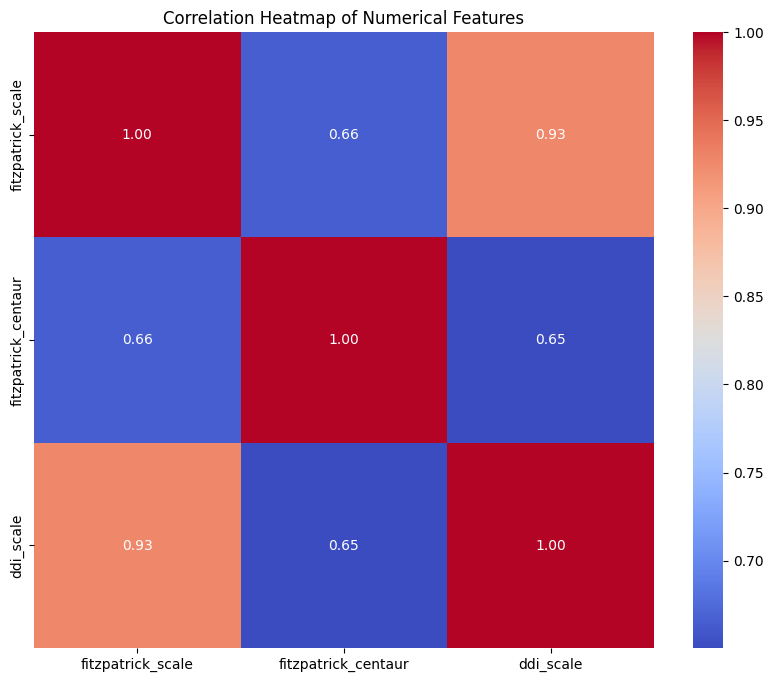

In [8]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
plt.figure(figsize=(10, 8))
corr = train_df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()